In [2]:
%load_ext autoreload

%autoreload 2

In [373]:
import os
import torch
import cv2

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

from torch.utils.data import Dataset, DataLoader, ConcatDataset, SubsetRandomSampler
from torchvision.transforms import transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim


import albumentations as A
from albumentations.pytorch import ToTensorV2

In [412]:
class ConcatenatedDataset(Dataset):
    def __init__(
        self, annotations_file, img_dir, transform_positives=None, transform_background=None, target_transform=None
    ):
        self.img_labels = pd.read_csv(annotations_file, header=None)
        self.img_dir = img_dir
        self.transform_positives = transform_positives  
        self.transform_background = transform_background 
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # image = Image.open(img_path)
        image = cv2.imread(img_path)
        
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.img_labels.iloc[idx, 1]
        if label == 0 and self.transform_background:
            image = self.transform_background(image=image)["image"]
        if label != 0 and self.transform_positives:
            image = self.transform_positives(image=image)["image"]
        # if self.transform:
        #     image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [154]:
class CustomImageDataset(Dataset):
    def __init__(
        self, annotations_file, img_dir, transform=None, target_transform=None
    ):
        self.img_labels = pd.read_csv(annotations_file, header=None)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = np.array(Image.open(img_path).convert("L"))
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [129]:
dataset_positives = CustomImageDataset(annotations_file="imgs_rect/positives_labels.csv", img_dir="imgs_rect")
dataset_background = CustomImageDataset(annotations_file="imgs_raw/labels.csv", img_dir="imgs_raw") # TODO transform=random_crop equals positives
dataset = ConcatDataset([dataset_positives, dataset_background])

dataloader = DataLoader(dataset_positives, batch_size=10)

In [ ]:
img, label = dataset[0]
print(img.shape)
plt.title('{}:{}'.format(label,labels_map[label]))
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [413]:
IMAGE_HEIGHT=224
IMAGE_WIDTH=224
transform = A.Compose([
        # A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.RandomCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, always_apply=True),
        A.Rotate(limit=35, p=1.0),
        # A.Normalize(),
        ToTensorV2(),
    ])
whole_dataset = ConcatenatedDataset(annotations_file="imgs_merged/labels.csv", img_dir="imgs_merged", transform_background=transform, transform_positives=transform)
whole_dataloader = DataLoader(whole_dataset, batch_size=10)

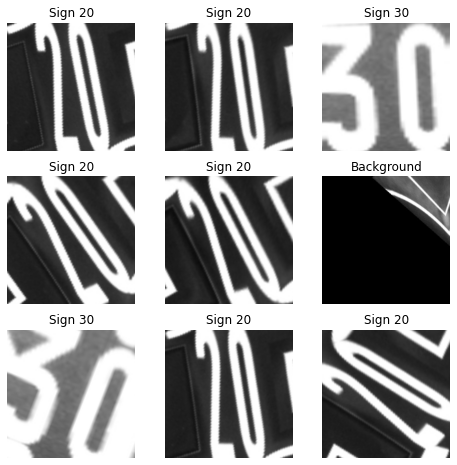

In [417]:
labels_map = {0: "Background", 1:"Sign 20", 2:"Sign 30"}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(whole_dataset), size=(1,)).item()
    img, label = whole_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.show()

In [301]:
df = whole_dataset.img_labels.reset_index()
splitter = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

splits = []
for train_idx, test_idx in splitter.split(df["index"], df[1]):
    splits.append((train_idx, test_idx))

In [431]:
# model
class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = torch.nn.Conv2d(3, 6, 5)
        self.conv2 = torch.nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = torch.nn.LazyLinear(120)  # 6*6 from image dimension
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 3)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        print(x.shape)
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        print(x.shape) 

        x = x.view(-1)
        print(x.shape)

        x = F.relu(self.fc1(x))
        print(x.shape)

        x = F.relu(self.fc2(x))
        print(x.shape)

        x = self.fc3(x)
        print(x.shape)

        return x

In [536]:
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    train_loss, train_correct = 0.0, 0
    model.train()
    for images, labels in dataloader:

        images, labels = images.to(device), labels.to(device)
        images = images.float()
        optimizer.zero_grad()
        output = model(images)
        print("output:", output.size())
        print("output:", output)

        print("labels:", labels.size())
        print("labels:", labels.float())
        loss = loss_fn(output, labels.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss, train_correct


In [537]:
NUM_EPOCHS=10
BATCH_SIZE=3
foldperf={}
criterion = nn.CrossEntropyLoss()

In [538]:
for fold, (train_idx, val_idx) in enumerate(splits):
    # print(f"{fold}-{train_idx}-{val_idx}")
    print("Fold {}".format(fold + 1))
    print(train_idx, val_idx)

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(
        whole_dataset, batch_size=BATCH_SIZE, sampler=train_sampler
    )
    test_loader = DataLoader(whole_dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = LeNet()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.002)

    # history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(NUM_EPOCHS):
        train_loss, train_correct = train_epoch(
            model, device, train_loader, criterion, optimizer
        )
    #     test_loss, test_correct=valid_epoch(model,device,test_loader,criterion)

    #     train_loss = train_loss / len(train_loader.sampler)
    #     train_acc = train_correct / len(train_loader.sampler) * 100
    #     test_loss = test_loss / len(test_loader.sampler)
    #     test_acc = test_correct / len(test_loader.sampler) * 100

    #     print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
    #                                                                                                          num_epochs,
    #                                                                                                          train_loss,
    #                                                                                                          test_loss,
    #                                                                                                          train_acc,
    #                                                                                                          test_acc))
    #     history['train_loss'].append(train_loss)
    #     history['test_loss'].append(test_loss)
    #     history['train_acc'].append(train_acc)
    #     history['test_acc'].append(test_acc)

    # foldperf['fold{}'.format(fold+1)] = history


Fold 1
[ 0  2  3  4  5  6  9 10 11 12 13 14 17 18 19 20 21 22 23 25 26 27 28 29
 30 31 32 33 34 35 36 37 39 40 41 42 43 45 48 49 50 51 54 56 57 58 62 63
 64 66 67 68 69 72 74 75 76 77 78 79 80 81 83] [ 1  7  8 15 16 24 38 44 46 47 52 53 55 59 60 61 65 70 71 73 82]
torch.Size([3, 6, 110, 110])
torch.Size([3, 16, 54, 54])
torch.Size([139968])
torch.Size([120])
torch.Size([84])
torch.Size([3])
output: torch.Size([3])
output: tensor([ 3.1714, -1.5362, -2.0869], grad_fn=<AddBackward0>)
labels: torch.Size([3])
labels: tensor([2., 1., 2.])


/Users/piotr/Documents/studia/SEM6/TWM/road-markings-detection/.venv/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

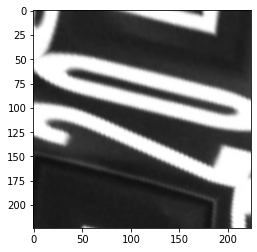

In [535]:
plt.imshow(next(iter(train_loader))[0][0].permute(1,2,0))

In [499]:
imgs, labels = next(iter(train_loader))
imgs.size()

torch.Size([16, 3, 224, 224])

In [467]:
conv1 = torch.nn.Conv2d(3, 6, 5)

In [468]:
conv1(imgs.float())[0]
len(imgs)

10

In [546]:
# x = imgs[0].view(-1)
# print(x.shape)
model = LeNet()
z = model(imgs.float())

# z = model(x)
print(z.size())
y = torch.softmax(z, dim=0)
# print(y)
criterion(y, torch.Tensor([8,7,3]).float())

/Users/piotr/Documents/studia/SEM6/TWM/road-markings-detection/.venv/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([16, 6, 110, 110])
torch.Size([16, 16, 54, 54])
torch.Size([746496])
torch.Size([120])
torch.Size([84])
torch.Size([3])
torch.Size([3])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

torch.Size([10, 6, 110, 110])
torch.Size([10, 16, 54, 54])
torch.Size([466560])
torch.Size([120])
torch.Size([84])
torch.Size([3])


tensor([ 1.5997,  1.4887, -0.4099], grad_fn=<AddBackward0>)

In [491]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
print(input.size())
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()
# Example of target with class probabilities
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)
output.backward()

torch.Size([3, 5])
